April: **Research Questions 1.A.4** (Ideal)

# Provided with upwelling-favourable wind forcing at the surface, what are the circulation patterns during an upwelling event in Mackenzie Canyon?

Circulation inside the canyon:

How does water flow around the canyon walls? Where in the canyon does water "turn" and what is the velocity of the flow.

In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import animation
from salishsea_tools.nc_tools import scDataset
from matplotlib import ticker
from matplotlib import colors
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import math
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions
import quicklook
import circulation_plots

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
import importlib
importlib.reload(quicklook)

<module 'quicklook' from '/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/quicklook.py'>

In [3]:
def get_uv_at_cross(dirname, fname, x_ind):
    
    filesU = general_functions.get_files(dirname, fname, 'grid_U')        
    filesV = general_functions.get_files(dirname, fname, 'grid_V')
    
    y = slice(1,-1,None)

    with scDataset(filesU) as dsU, scDataset(filesV) as dsV:
        vozocrtx0 = dsU.variables['vozocrtx'][:,:,y,x_ind]
        vomecrty0 = dsV.variables['vomecrty'][:,:,y,x_ind]
        sozotaux = dsU.variables['sozotaux'][:,0,0]
        depthu = dsU.variables['depthu'][:]
        depthv = dsV.variables['depthv'][:]

    with nc.Dataset(os.path.join(dirname, '1_mesh_mask.nc'), 'r') as dsM:
        umask0 = dsM.variables['umask'][0,:,y,x_ind]
        vmask0 = dsM.variables['vmask'][0,:,y,x_ind]
        e1u = dsM.variables['e1u'][0, y, x_ind]

    umask = np.tile(umask0, (len(sozotaux), 1, 1))
    vmask = np.tile(vmask0, (len(sozotaux), 1, 1))

    vozocrtx = np.ma.array(vozocrtx0, mask=1 - umask)
    vomecrty = np.ma.array(vomecrty0, mask=1 - vmask)
    
    return vozocrtx, vomecrty, umask[0, ...], vmask[0, ...], e1u, depthu, depthv, sozotaux

In [4]:
case = 'Base' 
dirname = '/ocean/imachuca/Canyons/results_mackenzie/extended_domain/ideal_base/'
fname = "1_MCKNZ_1h_20170101_201701*"

day0A, dep_ind0A = 2, 15
day0B, dep_ind0B = 3, 5

vozocrtx, vomecrty, vozocrtx0A, vomecrty0A, umask, vmask, e1u, e2u, depthu, depthv, sozotaux = quicklook.get_uv_at_depth_day(dirname, fname, dep_ind0A, day0A)
vozocrtx, vomecrty, vozocrtx0B, vomecrty0B, umask, vmask, e1u, e2u, depthu, depthv, sozotaux = quicklook.get_uv_at_depth_day(dirname, fname, dep_ind0B, day0B)

In [5]:
x_inds = [125, 130, 135, 140]

vozocrtxA, vomecrtyA, umaskA, vmaskA, e1u, depthu, depthv, sozotaux = get_uv_at_cross(dirname, fname, x_inds[0])
vozocrtxB, vomecrtyB, umaskB, vmaskC, e1u, depthu, depthv, sozotaux = get_uv_at_cross(dirname, fname, x_inds[1])
vozocrtxC, vomecrtyC, umaskC, vmaskC, e1u, depthu, depthv, sozotaux = get_uv_at_cross(dirname, fname, x_inds[2])
vozocrtxD, vomecrtyD, umaskD, vmaskD, e1u, depthu, depthv, sozotaux = get_uv_at_cross(dirname, fname, x_inds[3])

In [6]:
def plot_turning_cross_section(vozocrtx0A, vomecrty0A,
                               dep_ind0A, day0A,
                               vozocrtx0B, vomecrty0B,
                               dep_ind0B, day0B,
                               vozocrtxA, vomecrtyA, 
                               vozocrtxB, vomecrtyB,
                               vozocrtxC, vomecrtyC,
                               vozocrtxD, vomecrtyD,
                               umask, depthu, x_inds, vm, levels, case, flag):
    
    days = 6
    extra_rows=3
    cols = 4
    fig, axes = plt.subplots(days+extra_rows, cols, figsize=(20, 30), 
                             gridspec_kw={"height_ratios":[1.5,0.5,0.05,1,1,1,1,1,1]},sharey=True)
    for ax in axes[0, :]:
        ax.remove()
    for ax in axes[1, :]:
        ax.remove()
        
    cmap = cmo.cm.delta_r
    cmap.set_bad('silver')
    vmin, vmax = -1*vm, vm
          
        
    # --------------------------------------------------------------
    
    
    if flag == 'U':
        velA = vozocrtx0A #
        velB = vozocrtx0B
    elif flag == 'V':
        velA = vomecrty0A #
        velB = vomecrty0B
        
    for i, kind in zip([0, 2], ['A', 'B']):
        if kind == 'A':
            vel, day0, dep_ind0 = velA, day0A, dep_ind0A
            uvel, vvel = vozocrtx0A, vomecrty0A
            
        if kind == 'B':
            vel, day0, dep_ind0 = velB, day0B, dep_ind0B
            uvel, vvel = vozocrtx0B, vomecrty0B
        
        x_slice, y_slice, u_nstg, v_nstg, speeds = quicklook.get_speeds(uvel, vvel, 5) #
    
        ax = plt.subplot2grid((days+extra_rows, cols), (0, i), colspan=2, rowspan=2) #
        plot_vel = np.ma.array(vel, mask=1 - umask)
        p = ax.pcolormesh(plot_vel, cmap=cmap, vmin=vmin, vmax=vmax)
        ax.quiver(x_slice, y_slice, u_nstg, v_nstg, color='k',
                  clim=[0,vm], pivot='mid', width=0.005, headwidth=2.5, alpha=0.8)
        cs = ax.contour(plot_vel, levels = levels, alpha=0.8, linewidths=1.5)
        ax.clabel(cs, inline=1, fontsize=10, fmt = '%.1f')
        for line in cs.collections:
            line.set_linestyle([(None, None)])
            line.set_color('orangered')
        for x_ind in (x_inds):
            ax.axvline(x_ind, c='w', linewidth=1.5, alpha=0.8)
        ax.set_aspect(aspect='equal')
        #ax.xaxis.set_ticks(np.arange(0, x_slice[-1], 15))
        #ax.yaxis.set_ticks(np.arange(0, y_slice[-1], 15))
        ax.set_xlim([0, plot_vel.shape[-1]])
        ax.set_ylim([0, plot_vel.shape[-2]])
        ttls = 'Snapshot of average '+flag+' and flow\nfor day '+str(day0)+' and dep '+str(int(depthu[dep_ind0]))+' m'
        ax.set_title(ttls, fontsize=20)
    
    
    # --------------------------------------------------------------
    
    
    for x_ind, n in zip(x_inds, np.arange(axes.shape[1])):
        ax = axes[2, n]
        ax.axis("off")
        ax.set_title('x ind = '+str(x_ind), fontsize=30)
        fig.colorbar(p, ax=ax, fraction=1.5, orientation='horizontal')
    
        
    # --------------------------------------------------------------
    
    
    if flag == 'U':
        vels = [vozocrtxA, vozocrtxB, vozocrtxC, vozocrtxD]
    elif flag == 'V':
        vels = [vomecrtyA, vomecrtyB, vomecrtyC, vomecrtyD]
        
    for x_ind, vel, n in zip(x_inds, vels, np.arange(axes.shape[1])):
        for d, m in zip(np.arange(days), np.arange(extra_rows, axes.shape[0])):
            vel_daily = quicklook.get_1day_avg(vel, d, d+1) 
            ys = np.arange(vel_daily.shape[-1])
            ax = axes[m, n]
            p = ax.pcolormesh(ys, depthu, vel_daily, cmap=cmap, vmin=vmin, vmax=vmax)
            cs = ax.contour(ys, depthu, vel_daily, levels = levels, alpha=0.8, linewidths=1.5)
            ax.clabel(cs, inline=1, fontsize=10, fmt = '%.1f')
            for line in cs.collections:
                line.set_linestyle([(None, None)])
                line.set_color('r')
            if (d+1) == day0A:
                ax.axhline(depthu[dep_ind0A], c='k', lw=1.5)
            if (d+1) == day0B:
                ax.axhline(depthu[dep_ind0B], c='k', lw=1.5)
            ax.xaxis.set_ticks(np.arange(0, ys[-1], 15))
            ax.grid()
            ax.set_xlim([0, 200])
            ax.set_ylim([600, 0])
            ax.set_title('Day '+str(d+1), fontsize=20)
            
    
    # --------------------------------------------------------------
    
    
    fig.tight_layout(w_pad=0.3, h_pad=0.5)
    plt.subplots_adjust(top=0.94)
    fig.suptitle(case+' - '+flag+': Daily velocity average cross-sections', fontsize=30)
            
    return fig

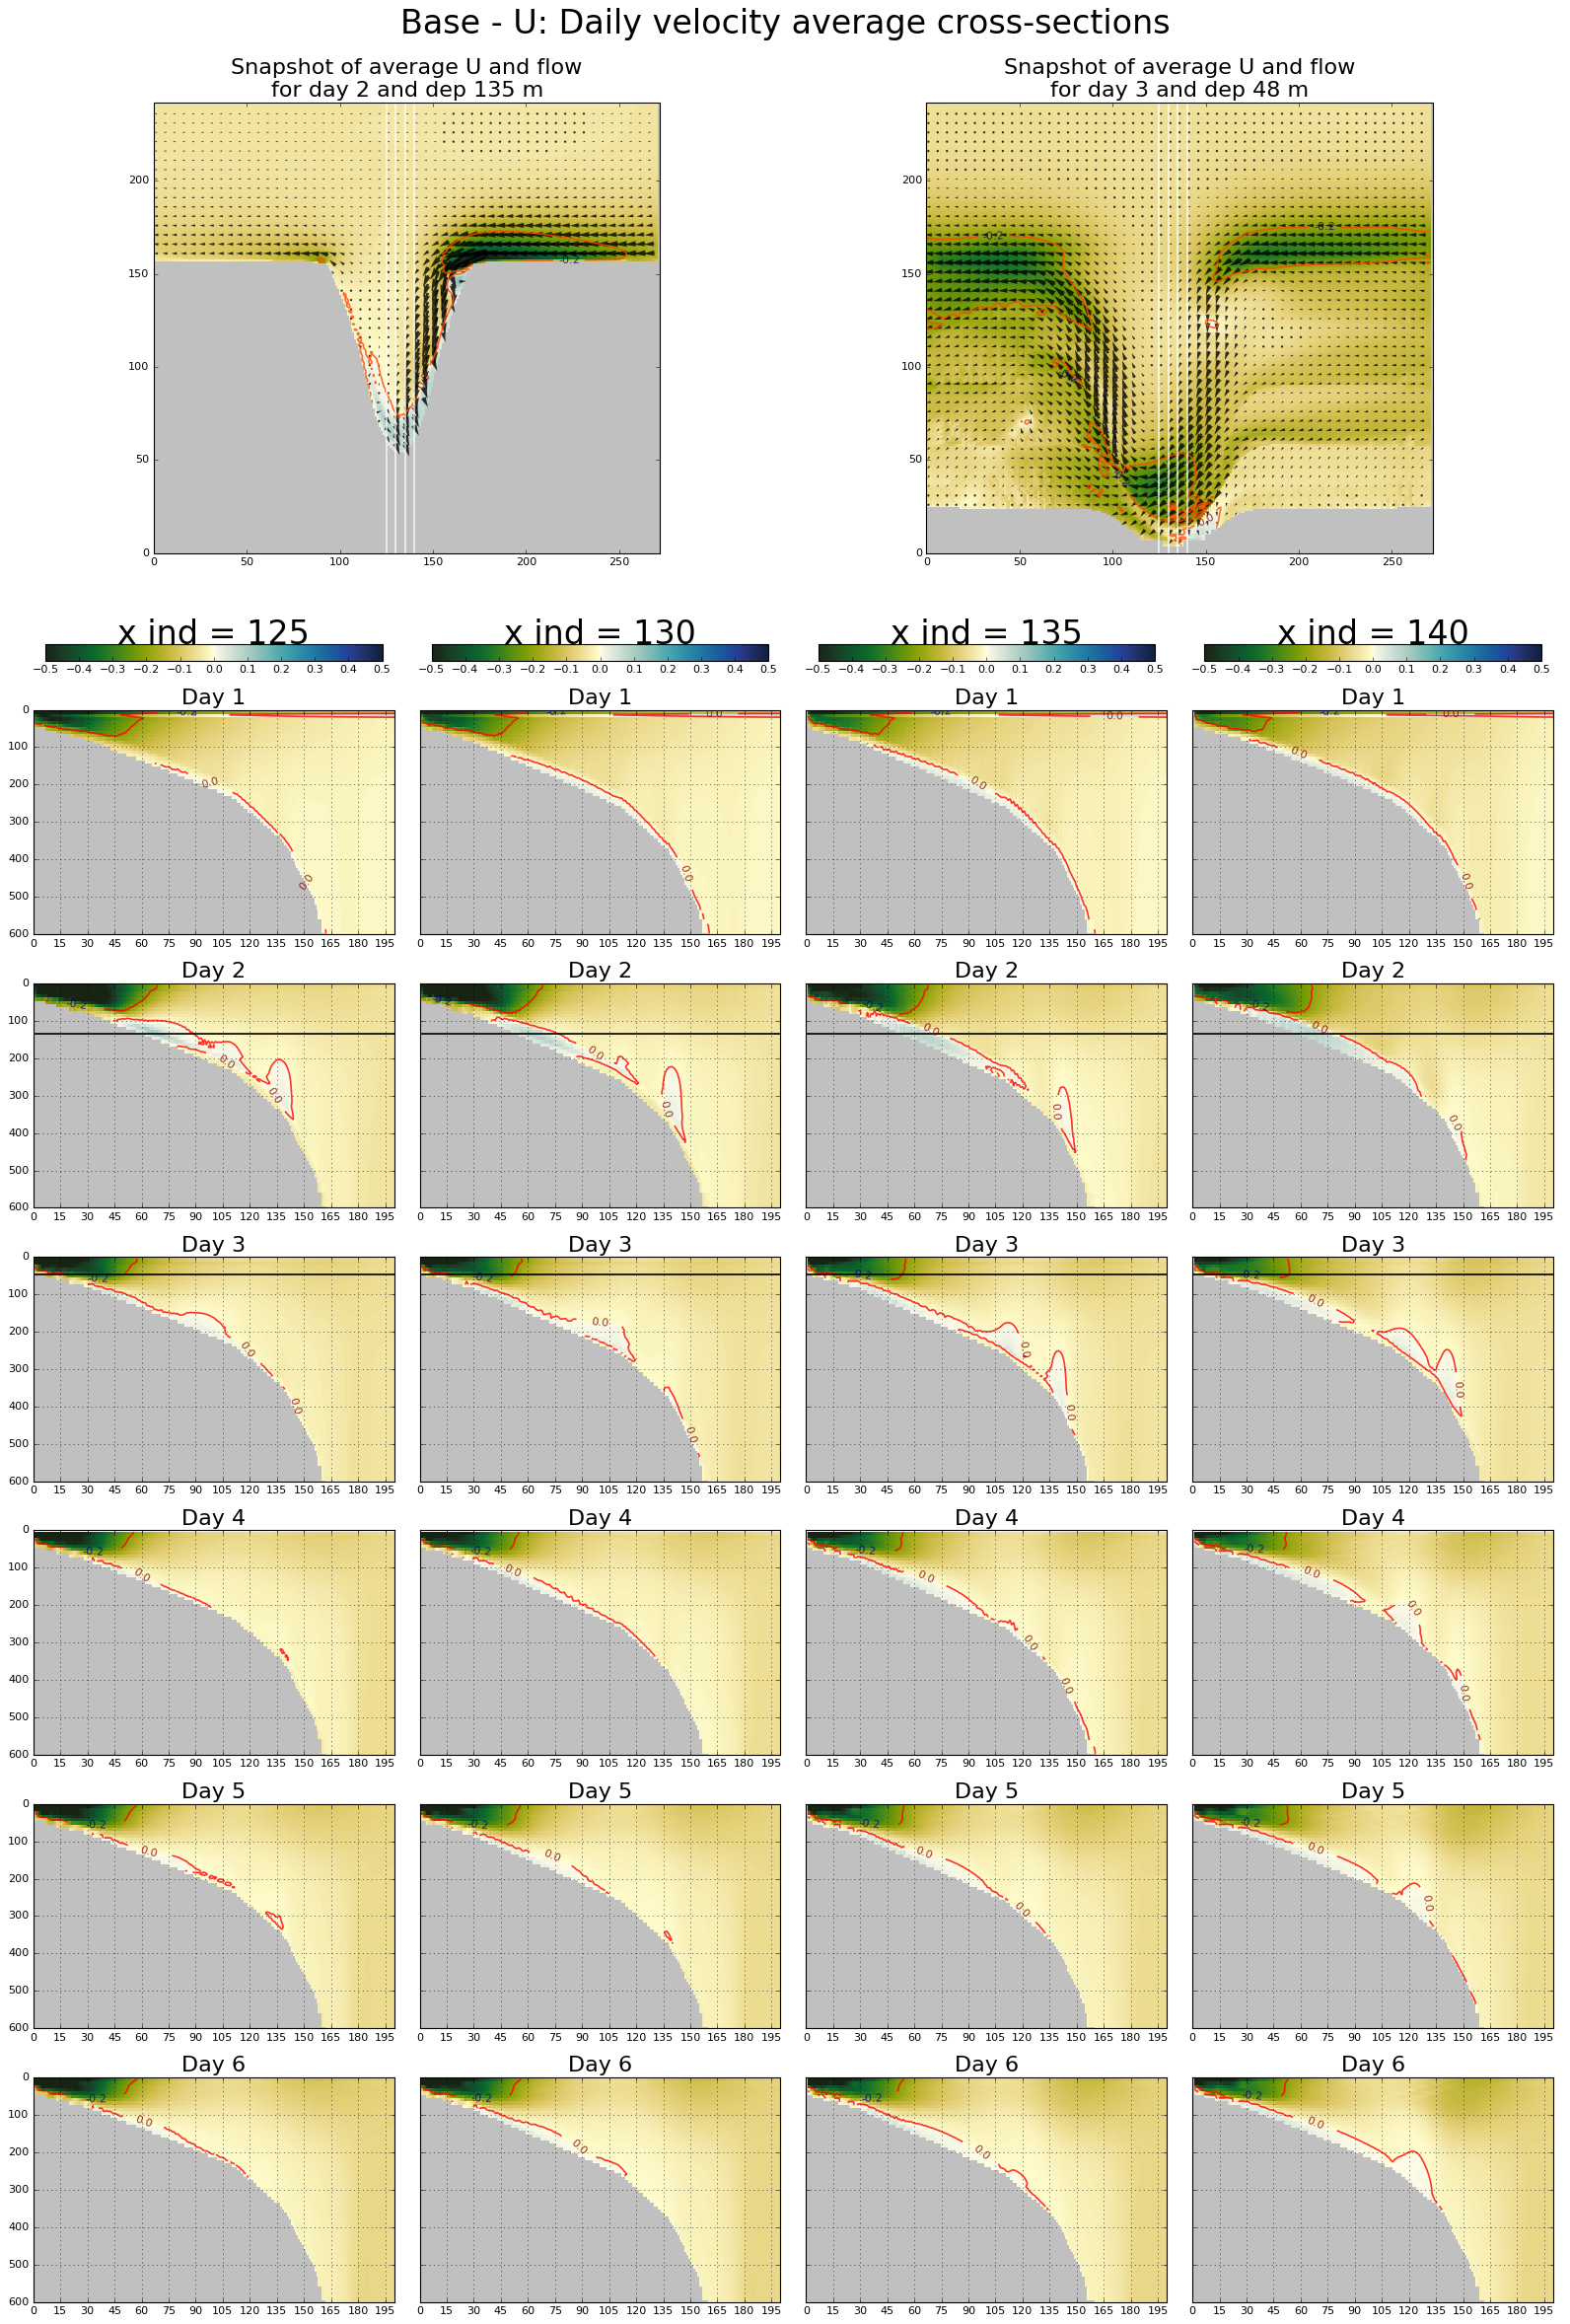

In [7]:
vm=0.5
levels = [-0.2, 0]
flag = 'U'
fig = plot_turning_cross_section(vozocrtx0A, vomecrty0A,
                               dep_ind0A, day0A,
                               vozocrtx0B, vomecrty0B,
                               dep_ind0B, day0B,
                               vozocrtxA, vomecrtyA, 
                               vozocrtxB, vomecrtyB,
                               vozocrtxC, vomecrtyC,
                               vozocrtxD, vomecrtyD,
                               umask, depthu, x_inds, vm, levels, case, flag)

fig.savefig('../writing_images/crosssections_xind'+str(int(np.mean(x_inds)))+'_'+case+'_'+flag+'1.png',
             dpi=100, bbox_inches='tight')

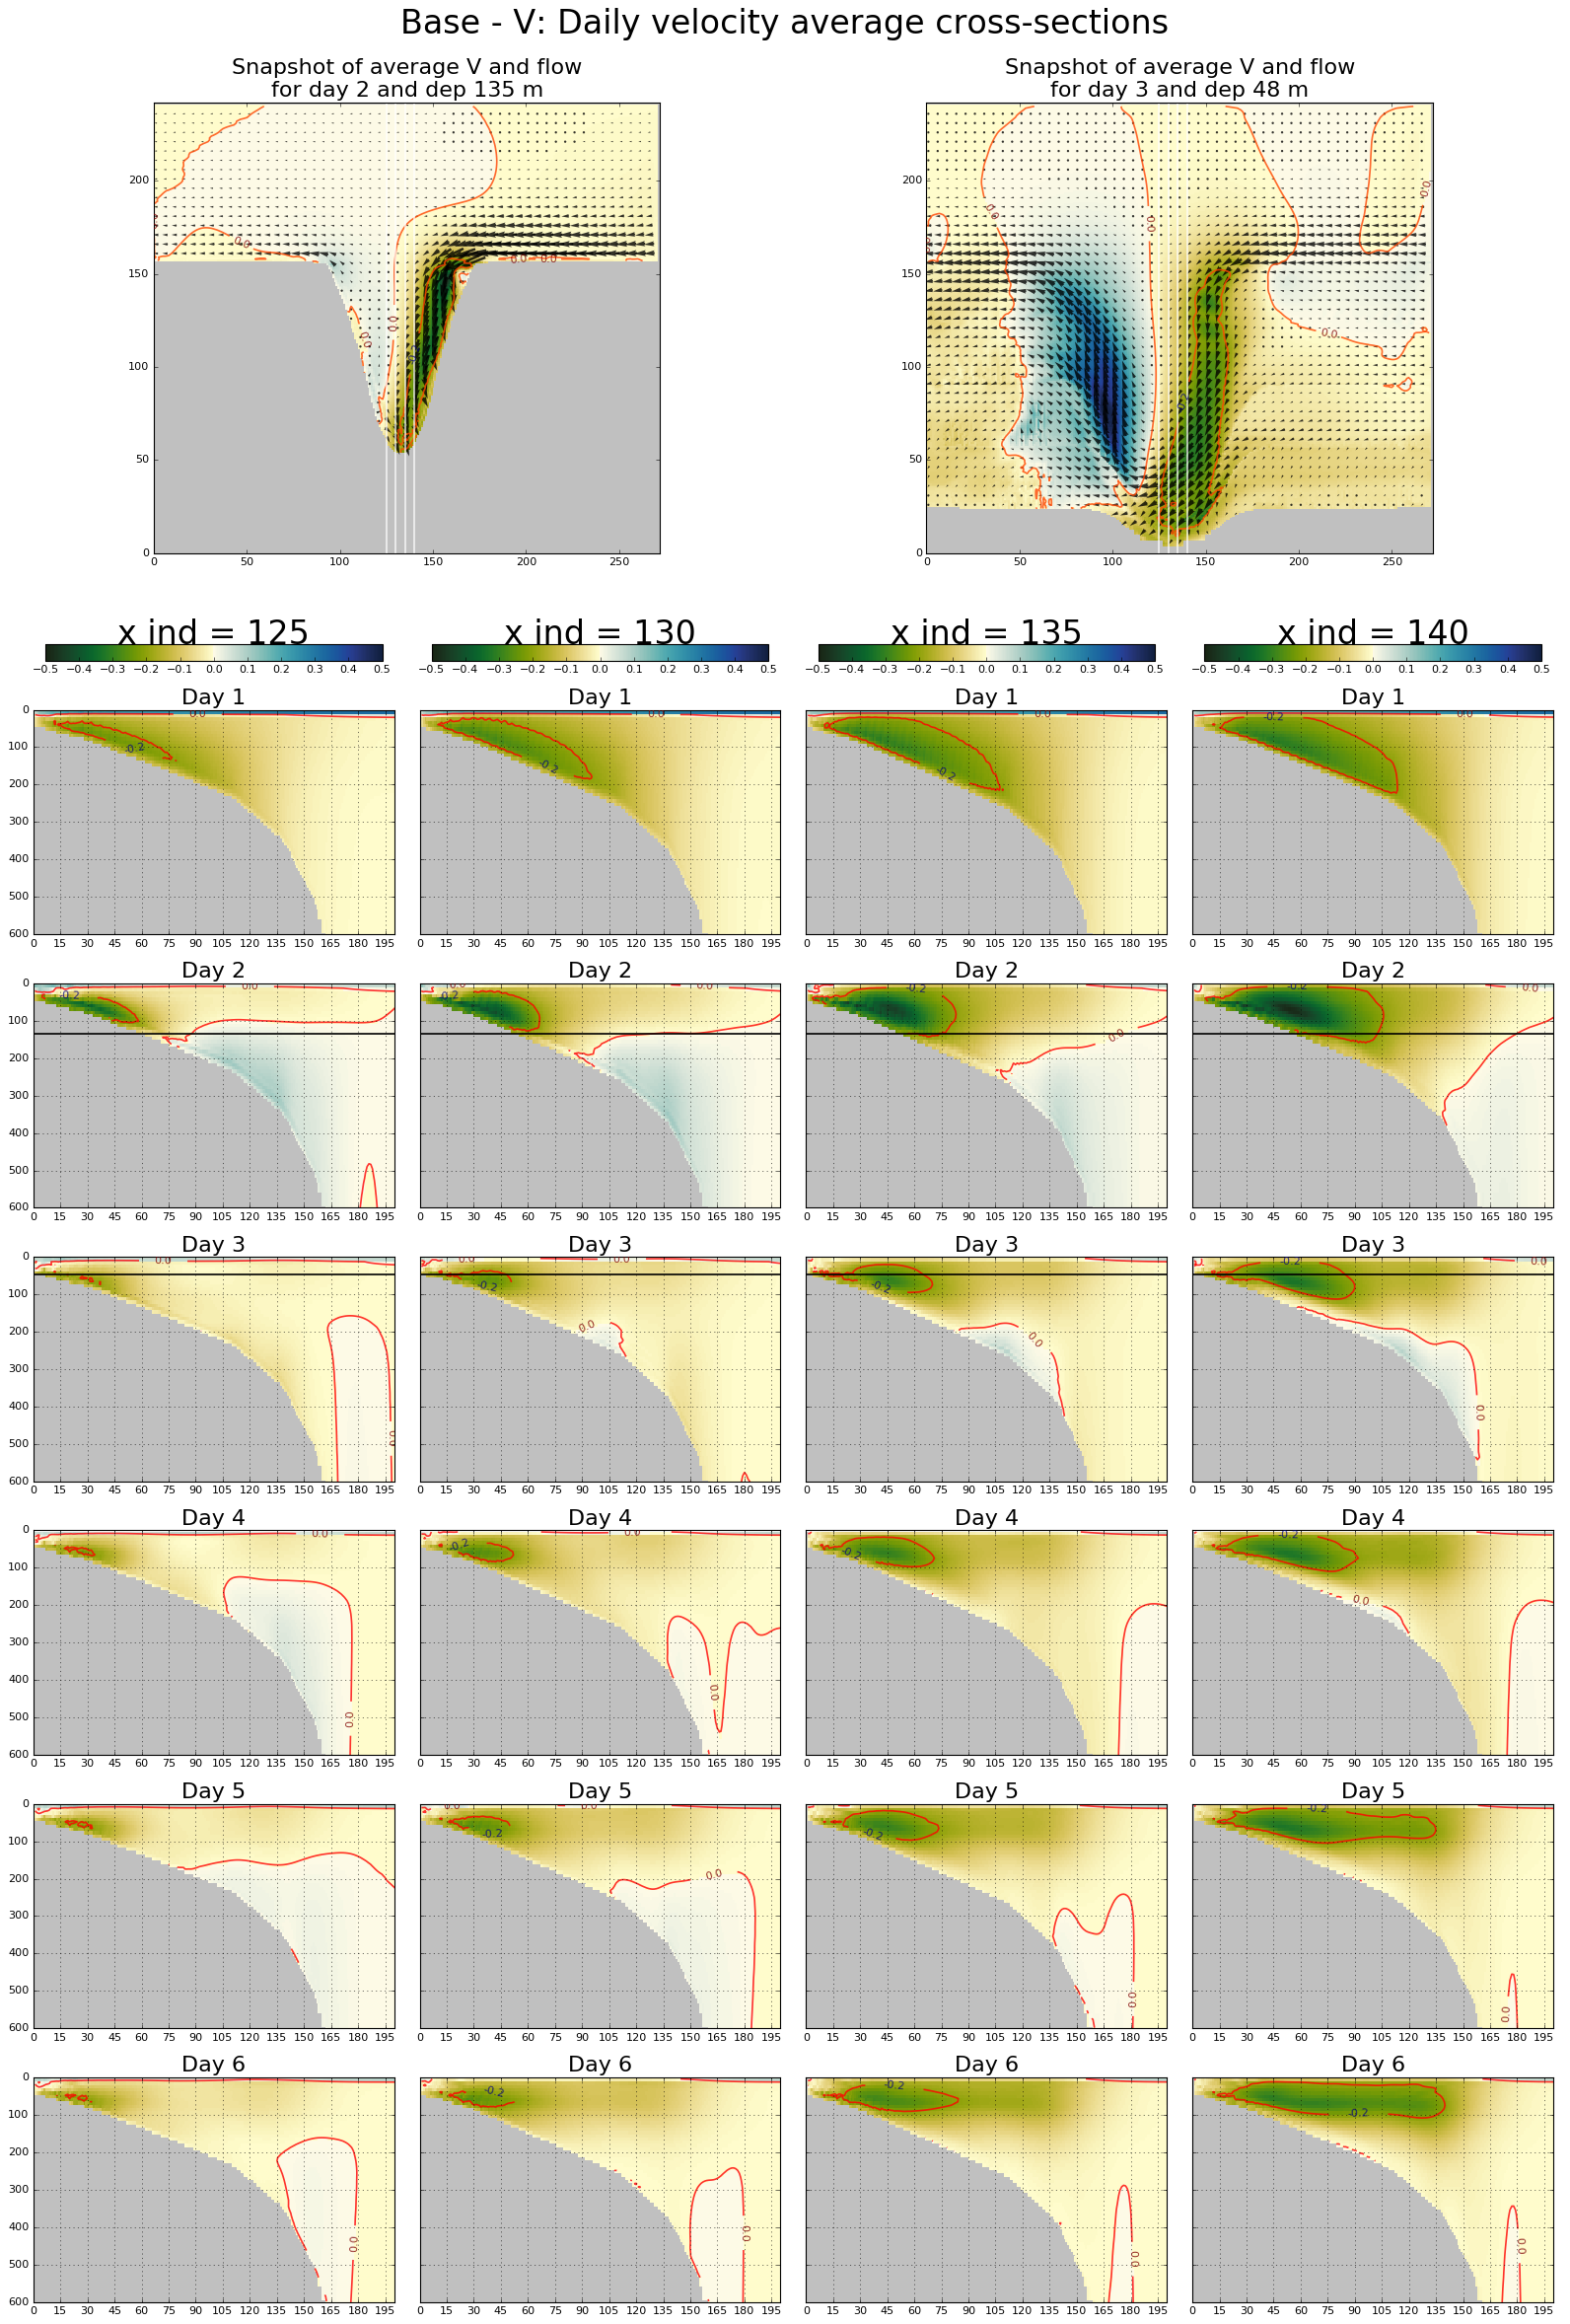

In [8]:
vm=0.5
levels = [-0.2, 0]
flag = 'V'
fig = plot_turning_cross_section(vozocrtx0A, vomecrty0A,
                               dep_ind0A, day0A,
                               vozocrtx0B, vomecrty0B,
                               dep_ind0B, day0B,
                               vozocrtxA, vomecrtyA, 
                               vozocrtxB, vomecrtyB,
                               vozocrtxC, vomecrtyC,
                               vozocrtxD, vomecrtyD,
                               umask, depthu, x_inds, vm, levels, case, flag)

fig.savefig('../writing_images/crosssections_xind'+str(int(np.mean(x_inds)))+'_'+case+'_'+flag+'1.png',
             dpi=100, bbox_inches='tight')